## Figure 2: Performance of the full perturbative error mitigation 

We will show the performance of the _general_ truncation scheme to recover the full bitstring distribution, as a function of cutoff weight $w$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import utils
import response_matrix

In [7]:
# Utilities for making probability distributions

def make_uniform(n):
    """Make the uniform distribution over n qubits."""
    d = 1 << n
    return np.ones(d) / d

def make_random(n):
    d = 1 << n
    out = np.random.rand(d)
    return out / out.sum()

def trace_dist(a, b):
    # use trace distance for comparing full distributions
    return abs(a - b).sum()


### Compute the corrected prob distribution using Algorithm 1

##  experiments

2. Second exeriment: Fix $n$, then plot $d(p, \tilde{p})$ as a function of $q$ for changing w cutoff


Recall how we do the inversion:
$$
(I-A)^{-1} = \sum_{k=0}^\infty A^k
$$

So After defining $R =R_0 + \sum_j R_j \rightarrow R^{-1} = (I + \sum_j R_0^{-1} R_j )^{-1} R_0^{-1}$ we define $A = -\sum_j R_0^{-1} R_j$ so that 
$$
(I + \sum_j R_0^{-1} R_j )^{-1} = (I - A)^{-1}
$$
converges only for
$$
||A|| = ||\sum_j R_0^{-1} R_j || < 1
$$

In [29]:
def make_neumann_test_mat(Rmat, w):
    """Construct the above matrix that must have norm bounded by 1"""
    d = R.shape[0]
    n = int(np.log2(d))
    
    out = np.zeros_like(R)
    
    Rdiag_inv = np.zeros_like(Rmat, dtype=float)
    Rdiag_inv[np.diag_indices(d)] = np.reciprocal(np.diag(R))
    
    for j in range(1, w + 1):
        Rj = np.zeros_like(Rmat)
        Rj[response_matrix.slice_for_Rj(n, j)] = Rmat[response_matrix.slice_for_Rj(n, j)]
        out -= Rdiag_inv @ Rj
    return out

In [38]:
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

ntrials = 5
qvals = np.linspace(0.01, 0.21,  22)
n_qubits = 8
wvals = [1, 2, 3, 4]

# Outcomes contain truncated result comparisons
q_outcomes = np.zeros((len(wvals) + 1, len(qvals), ntrials)) # rows correspond to w=0, 1,2...

# compute spectral nroms for associated neumann series term
neumann_norms = np.zeros((len(wvals) + 1, len(qvals), ntrials)) 

for trial in range(ntrials):
    for j, qmax in enumerate(qvals):
        # Generate response matrix and artificial readout error
        R = response_matrix.generate_characteristic_R(qmax, n_qubits)
        

        Rinv = np.linalg.inv(R)
        p_true = make_random(n_qubits)
        p_prime = R @ p_true

        # Full distribution correction
        q_outcomes[0, j, trial] = trace_dist(p_prime, p_true)
        for k, w in enumerate(wvals):
            # Decompose to generate the primary term in the neumann expansion
            Rj_test_sum = make_neumann_test_mat(R, w)
            neumann_norms[k + 1,j, trial] = np.linalg.norm(Rj_test_sum, 2)
            
            # Actually back out the fix
            p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
            q_outcomes[k + 1,j, trial] = trace_dist(p_fixed, p_true)

# np.save("{}qubits_scaling_results.npy".format(n_qubits), q_outcomes)

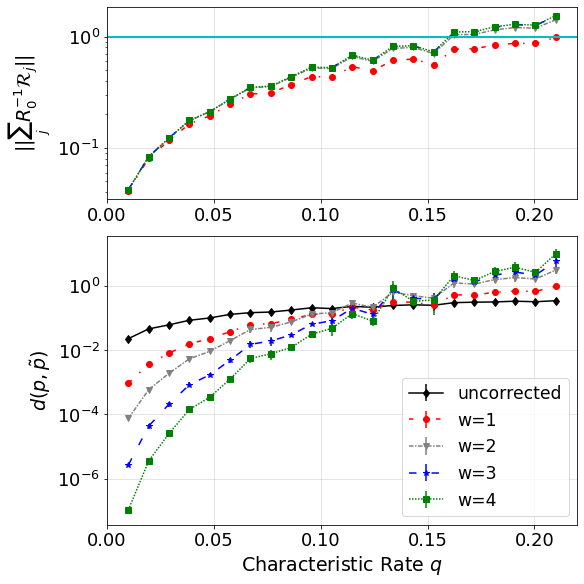

In [49]:
plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 1, figsize=(8, 8), constrained_layout=True, gridspec_kw={'height_ratios': [2, 3]})


# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

neumann_avg_outcomes = neumann_norms.mean(axis=2)
for j, y in enumerate(neumann_avg_outcomes):
    axes[0].plot(qvals, y, marker=markers_2[j], ls=linestyles[j], c=colors[j])
axes[0].axhline(1, c='c', lw=2)
axes[0].set_ylabel(r"$||\sum_j R_0^{-1} \mathcal{R}_j||$")

q_avg_outcomes = q_outcomes.mean(axis=2)
q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
# q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
for j, y in enumerate(q_avg_outcomes):
    confidence = q_var_outcomes[j]
    axes[1].errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])

    
axes[1].set_xlabel(r"Characteristic Rate $q$")
axes[1].legend(leglabels)
axes[1].set_yticklabels(axes[0].get_yticklabels())
axes[1].set_ylabel(r"$d(p, \tilde{p})$")

# Formatting for both
for ax in axes:
#     ax.set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
    ax.grid(True, alpha=0.4)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

In [67]:
qmax = 0.10

for n_qubits in [6, 8, 10]:
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
#     p_true = make_random(n_qubits)
#     p_prime = R @ p_true
    Rdiag = np.diag(R)
    Roffdiag = np.copy(R)
    Roffdiag[np.diag_indices(R.shape[0])] = 0
    Roffdiag_test = abs(Roffdiag).sum(axis=1)
    print(np.all(Rdiag > Roffdiag_test))


True
True
True


In [24]:
n_qubits = 6
qmax = 0.24

R = response_matrix.generate_characteristic_R(qmax, n_qubits)
print("spectral norm:", np.linalg.norm(R, 2))
w1_arr = range(1, 2 * n_qubits)
w2_arr = range(1, n_qubits)
p_true = make_random(n_qubits)
p_prime = R @ p_true

accs = np.zeros((len(w1_arr), len(w2_arr)))
norms = np.zeros((len(w1_arr), len(w2_arr)))
for i, w1 in enumerate(w1_arr):
    for j, w2 in enumerate(w2_arr):
        x = response_matrix.invert_pfull_truncated(R, p_prime, w1=w1, w2=w2)
        norms[i,j] = x.sum()
        accs[i,j] = trace_dist(x, p_true)


spectral norm: 1.1134727763180958


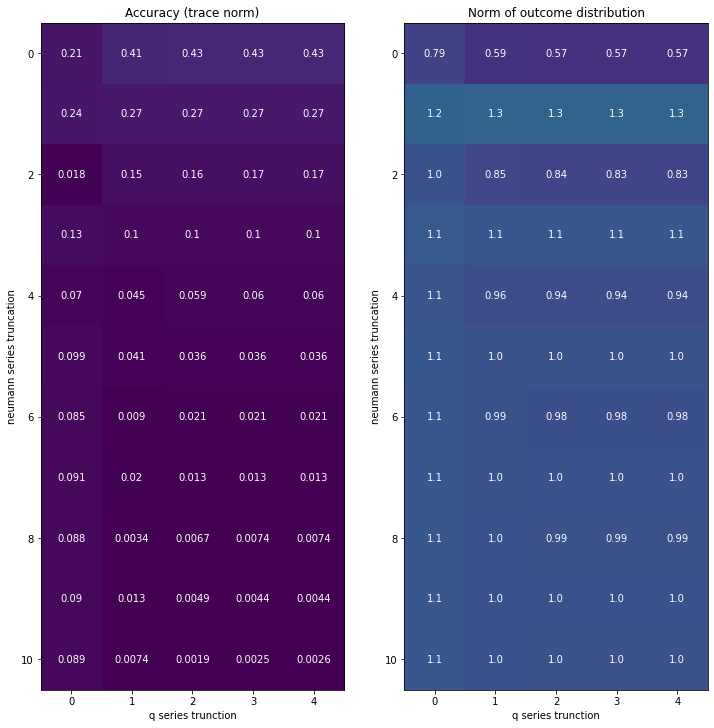

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,10), constrained_layout=True)
axes[0].imshow(accs, vmin=0, vmax=4)
axes[1].imshow(norms, vmin=0, vmax=4)

for axj, arr in enumerate([accs, norms]):
    for i in range(len(w1_arr)):
        for j in range(len(w2_arr)):
            text = axes[axj].text(j, i, f"{arr[i, j]:3.2}",
                           ha="center", va="center", color="w")  
for ax in axes:
    ax.set_xlabel("q series trunction")
    ax.set_ylabel("neumann series truncation")
axes[0].set_title("Accuracy (trace norm)")
axes[1].set_title("Norm of outcome distribution")
plt.show()